<a href="https://colab.research.google.com/github/GrigoryBartosh/dul_2021/blob/main/Homework/hw1/Homework1_MADE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 1

In [ ]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone --single-branch --branch utils https://github.com/GrigoryBartosh/dul_2021
!unzip -qq dul_2021/Homework/hw1/data/hw1_data.zip -d dul_2021/Homework/hw1/data/
!mv -v dul_2021/Homework/hw1/data/hw1_data/* dul_2021/Homework/hw1/data/
!rmdir dul_2021/Homework/hw1/data/hw1_data/
!pip install ./dul_2021

In [ ]:
from dul_2021.utils.hw1_utils import *

In [ ]:
plt.rcParams["axes.labelsize"] = 25.
plt.rcParams["xtick.labelsize"] = 20.
plt.rcParams["ytick.labelsize"] = 20.
plt.rcParams["legend.fontsize"] = 18.

plt.rcParams["figure.figsize"] = [8., 6.]

# MADE

In this question, you will implement [MADE](https://arxiv.org/abs/1502.03509). In the first part, you will use MADE to model a simple 2D joint distribution, and in the second half, you will train MADE on image datasets.

## Part (a) Fitting 2D Data

First, you will work with bivariate data of the form $x = (x_0,x_1)$, where $x_0, x_1 \in \{0, \dots, d\}$. We can easily visualize a 2D dataset by plotting a 2D histogram. Run the cell below to visualize our datasets.

Dataset 1


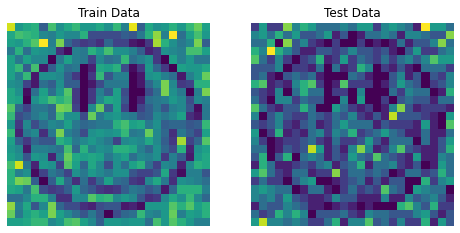

Dataset 2


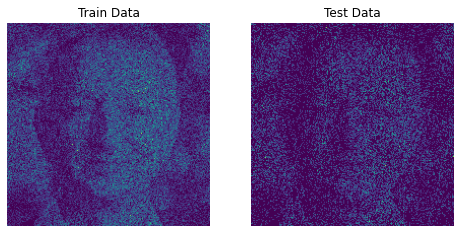

In [ ]:
visualize_q1a_data(dset_type=1)
visualize_q1a_data(dset_type=2)
# you can access data with get_data_q1_a(dset_type=1)

Implement and train a MADE model through maximum likelihood to represent $p(x_0, x_1)$ on the given datasets, with any autoregressive ordering of your choosing. 

A few notes:
* You do not need to do training with multiple masks
* You made find it useful to one-hot encode your inputs. 

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Visualize the learned 2D distribution by plotting a 2D heatmap


### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def one_hot(batch, d):
    # print(batch.shape)
    res = torch.zeros(batch.shape[0], d)
    res[np.arange(len(batch)), batch] = 1
    return res

In [ ]:
class MaskedLinear(nn.Linear):    
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)        
        self.register_buffer('mask', torch.ones(out_features, in_features))
        
    def set_mask(self, mask):
        self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8).T))
        
    def forward(self, input):
        return F.linear(input, self.mask * self.weight, self.bias)

In [ ]:
class MADE(nn.Module):
    def __init__(self, input_shape, d, hidden_size, num_masks=1):
        super().__init__()
        self.input_shape = input_shape
        self.nin = np.prod(input_shape)
        self.nout = self.nin * d
        self.hidden_size = hidden_size
        self.d = d
        
        self.net = []
        hs = [self.nout] + hidden_size + [self.nout]
        for h0,h1 in zip(hs, hs[1:]):
            self.net.extend([
                    MaskedLinear(h0, h1),
                    nn.ReLU(),
                ])
        self.net.pop() 
        self.net = nn.Sequential(*self.net)
                
        self.m = {}
        self.update_mask() 
        
    def update_mask(self):
        L = len(self.hidden_size)
                
        self.m[-1] = np.arange(self.nin)
        for l in range(L):
            self.m[l] = np.random.randint(self.m[l-1].min(), self.nin-1, size=self.hidden_size[l])
        
        masks = [self.m[l-1][:,None] <= self.m[l][None,:] for l in range(L)]
        masks.append(self.m[L-1][:,None] < self.m[-1][None,:])
        
        masks[-1] = np.repeat(masks[-1], self.d, axis=1)
        masks[0] = np.repeat(masks[0], self.d, axis=0)
        
        layers = [l for l in self.net.modules() if isinstance(l, MaskedLinear)]
        for l,m in zip(layers, masks):
            l.set_mask(m)
    
    def forward(self, x):
        xe = one_hot(x.long().reshape(-1), self.d).reshape(x.shape[0], -1)
        out = self.net(xe).reshape(x.shape[0], self.nin, self.d)
        return out.permute(0, 2, 1).view(x.shape[0], self.d, *self.input_shape)

    def loss(self, x):
        return F.cross_entropy(self(x), x.long())
    
    def test(self, testloader):
        loss = 0
        tl = 0
        with torch.no_grad():
            for batch in testloader:
                loss += self.loss(batch) * batch.shape[0]
                tl += batch.shape[0]
        return loss / tl
    
    def fit(self, train_data, test_data, epochs=100, lr=1e-1, batch_size=128):
        trainloader = torch.utils.data.DataLoader(train_data,
                                                  batch_size=batch_size, 
                                                  shuffle=True)
    
        testloader = torch.utils.data.DataLoader(test_data,
                                                 batch_size=batch_size)
        

        train_loss = []
        test_loss = []
        test_loss.append(self.test(testloader))
        optim = opt.Adam(self.parameters(), lr=lr)
        
        for epoch in range(epochs):
            for batch in trainloader:
                loss = self.loss(batch)
                optim.zero_grad()
                loss.backward()
                optim.step()
                train_loss.append(loss)
            test_loss.append(self.test(testloader))
        return train_loss, test_loss 

    def sample(self, n):
        samples = torch.zeros(n, self.nin)
        m = np.arange(self.nin)
        for i in range(self.nin):
            logits = self(samples).view(n, self.d, self.nin)[:, :, m[i]]
            probs = F.softmax(logits, dim=1)
            samples[:, m[i]] = torch.multinomial(probs, 1).squeeze(-1)
        samples = samples.view(n, *self.input_shape)
        return samples.cpu().numpy()
    
    def probabilities(self):
        x = np.empty(2)
        for i in range(self.d):
            for j in range(self.d):
                x = np.vstack((x, np.array([i, j])))
        x = x[1:].astype(int)
        x = torch.Tensor(x).long()
        probs = F.softmax(self(x), dim=1)
        probs = probs[np.arange(self.d * self.d), x[:, 0], 0] * probs[np.arange(self.d * self.d), x[:, 1], 1]
        return probs.reshape(self.d, self.d).cpu().detach().numpy()

In [ ]:
def q1_a(train_data, test_data, d, dset_id):
    """
    train_data: An (n_train, 2) numpy array of integers in {0, ..., d-1}
    test_data: An (n_test, 2) numpy array of integers in {0, .., d-1}
    d: The number of possible discrete values for each random variable x1 and x2
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (d, d) of probabilities (the learned joint distribution)
    """

    model = MADE((2,), d, [100, 100])
    tr_loss, test_loss = model.fit(train_data, test_data, lr=1e-3, batch_size=256, epochs=5)
    probs = model.probabilities()
    return tr_loss, test_loss, probs

### Results

Once you've implemented `q2_a`, execute the cells below to visualize and save your results



In [ ]:
q1_save_results(1, 'a', q1_a)

In [ ]:
q1_save_results(2, 'a', q1_a)

## Part (b) Shapes and MNIST
Now, we will work with a higher dimensional datasets, namely a shape dataset and MNIST. Run the cell below to visualize the two datasets

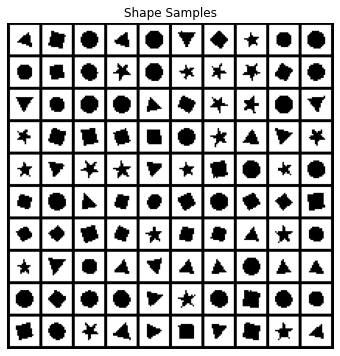

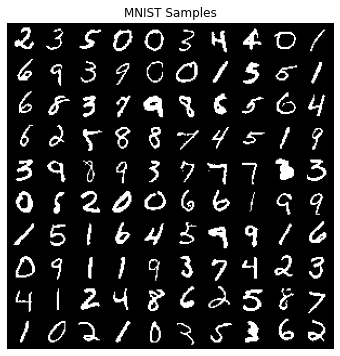

In [ ]:
visualize_q1b_data(1)
visualize_q1b_data(2)
# you can access data with get_data_q1_b(dset_type=1)

Implement and train a MADE model on the given binary image datasets. Given some binary image of height $H$ and width $W$, we can represent image $x\in \{0, 1\}^{H\times W}$ as a flattened binary vector $x\in \{0, 1\}^{HW}$ to input into MADE to model $p_\theta(x) = \prod_{i=1}^{HW} p_\theta(x_i|x_{<i})$. Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine).

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q1_b(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    test_data: An (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    image_shape: (H, W), height and width of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
    """

    H, W = image_shape

    model = MADE((H, W, 1), 2, [100, 100])
    tr_loss, test_loss = model.fit(train_data, test_data, lr=1e-3, batch_size=256, epochs=10)
    samples = model.sample(100)
    return tr_loss, test_loss, samples

### Results

Once you've implemented `q2_b`, execute the cells below to visualize and save your results



Final Test Loss: 0.1371


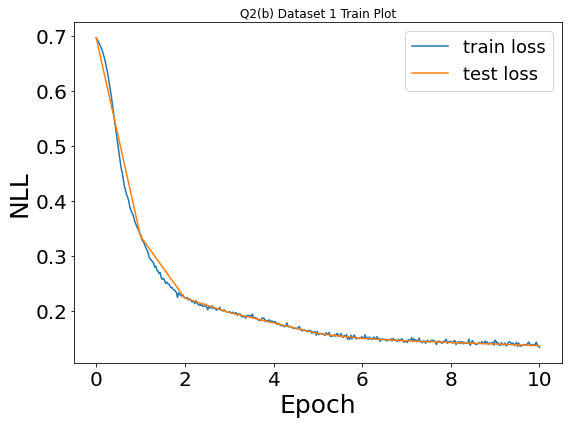

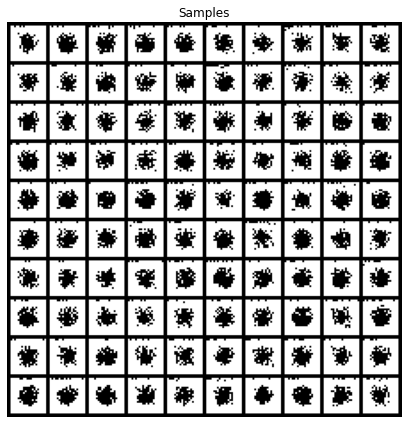

In [ ]:
q1_save_results(1, 'b', q1_b)

Final Test Loss: 0.1911


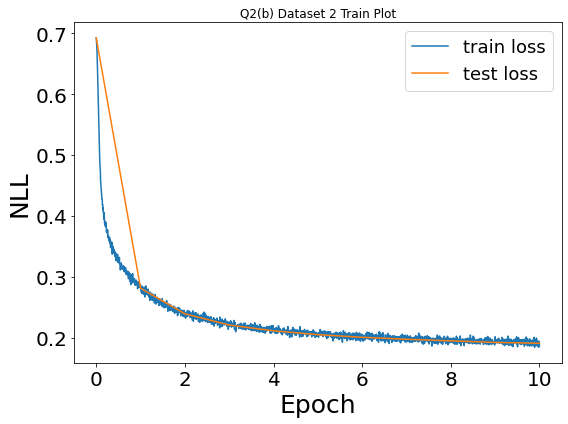

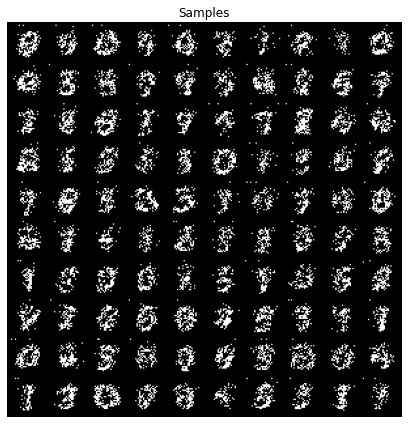

In [ ]:
q1_save_results(2, 'b', q1_b)